# Búsqueda de parámetros de predicción

Ensayo de variables explicativas (atributos de parcela) para la estimación del usdm2

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

## 1. Variables explicativas externas 

Información extraída de la [API de catastro](https://datosabiertos-apis.buenosaires.gob.ar/BA_Root/Documentacion?schema_name=catastro) de GCBA.

In [2]:
xvars_df = pd.read_csv('../data/expvars_12092022.csv', index_col='smp')

In [3]:
xvars_df.sample(2)

,superficie_total,superficie_cubierta,frente,fondo,propiedad_horizontal,pisos_bajo_rasante,pisos_sobre_rasante,unidades_funcionales,locales,vuc,cantidad_puertas,lon_ctroid,lat_ctroid
smp,,,,,,,,,,,,,
082-005-037,150.0,108.0,8.66,17.32,0.0,0.0,1.0,0.0,0.0,0.0,1.0,98722.030533,93031.682152
052-073-037,220.0,120.0,8.66,25.41,0.0,0.0,1.0,0.0,0.0,0.0,1.0,102591.019407,96496.969161


In [4]:
xvars_df.columns

Index(['superficie_total', 'superficie_cubierta', 'frente', 'fondo',
       'propiedad_horizontal', 'pisos_bajo_rasante', 'pisos_sobre_rasante',
       'unidades_funcionales', 'locales', 'vuc', 'cantidad_puertas',
       'lon_ctroid', 'lat_ctroid'],
      dtype='object')

In [5]:
expvars = ['superficie_total', 'superficie_cubierta', 'frente', 'fondo',
           'propiedad_horizontal', 'pisos_bajo_rasante', 'pisos_sobre_rasante',
           'unidades_funcionales', 'locales', 'vuc', 'cantidad_puertas',
           'lat_ctroid', 'lon_ctroid']

## 2. Target de prediccion 

In [6]:
from REM.properaty_data import *
from REM.datasources import *

In [7]:
# construcción del area de recorte 
thiner_path = '../data/BarOli_V1/layers/P_BP_AREA_5347.shp'
mascara = thiner_bound(path=thiner_path)
parcelas = caba_parcelas(source_idx=1)
parcelas_sur = build_study_area(parcelas, mascara)

# tipo de oferta inmobiliaria
property_type = 'demolicion' 
propiedades = read_local_properati(path='../data/oferta_residencial_properaty.csv')
propiedades.start_date = pd.to_datetime(propiedades.start_date)
propiedades_target = properaty_observed_prices(propiedades, parcelas_sur, property_type)

# precios por parcela
ref_price = propiedades_target.groupby('smp')[['price_adj','usdm2','usdm2_f']].mean()
parcelas_sur['usdm2'] = parcelas_sur['smp'].map(ref_price['usdm2'])
parcelas_sur['usdm2_f'] = parcelas_sur['smp'].map(ref_price['usdm2_f']) # asumiendo sup mediana
parcelas_sur['price_adj'] = parcelas_sur['smp'].map(ref_price['price_adj'])
parcelas_sur.replace([np.inf, -np.inf], np.nan, inplace=True)

Reading parcels from local dir ...


/home/federico/federico/CEEU/bolimpico/REM/REM/datasources.py:92: UserWarning: Los sistemas de coordenadas difieren. Adaptando mascara a CRS de parcelas
  warnings.warn("Los sistemas de coordenadas difieren. Adaptando mascara a CRS de parcelas")


Cantidad de avisos informan superficie:
***************************************
True     841
False    769
Name: surface_total, dtype: int64
Tipo de oferta: Terreno


Los valores observados se construyen a partir del precio promedio dentro del polígono de la parcela. El mismo se construye a través del conjunto de avisos georreferenciados publicados en el portal inmobiliario (Properati). 

Las parcelas sin precio pueden ser el resultado de:

* Falta de limpieza en el Points dataset (observaciones sin superficie)
* Poca cantidad de Points (se cubre un numero bajo de parcelas porque en ellas no hay oferta - mas alla de la cantidad de puntos del dataset)

A los fines de entrenar el modelo con un mayor volumen de oferta, de disponibiliza el campo `usdm2_f`. Para este cálculo se imputa la superficie mediana en los avisos que no cuentan con dicha información.

In [8]:
target_var = 'usdm2_f'

parcelas_cprecio = parcelas_sur[~parcelas_sur[target_var].isna()].copy()
parcelas_sprecio = parcelas_sur[parcelas_sur[target_var].isna()].copy()

In [9]:
# total parcelas con precio
len(parcelas_cprecio)

394

In [10]:
# total parcelas en el area de recorte
len(parcelas_sur)

28070

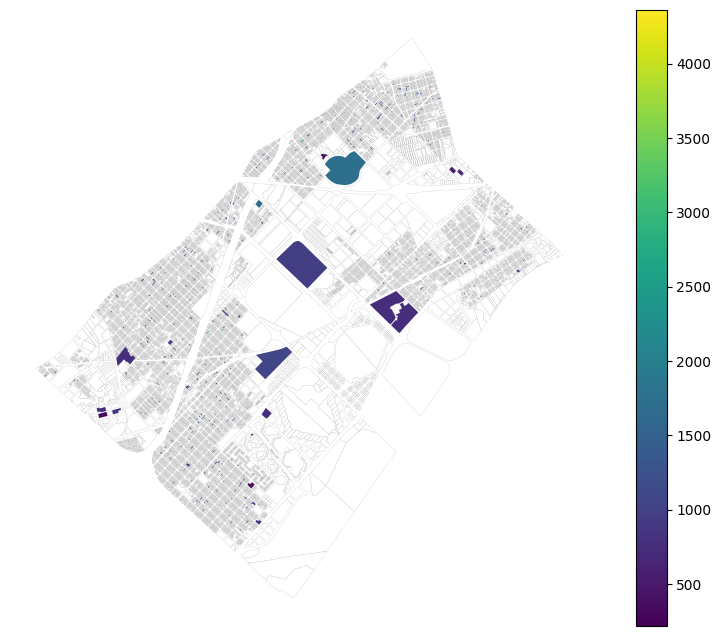

In [12]:
f, ax = plt.subplots(figsize=(12,8));
parcelas_sprecio.plot(ax=ax, color='white', linewidth=0.1, alpha=0.9, edgecolor='grey')
parcelas_cprecio.plot(column=target_var, ax=ax, legend=True) # con precio de oferta
ax.set_axis_off();

## 3. Variables explicativas internas 

Se estiman el área y atributos de vecindad de las parcelas.

In [13]:
gkbs = '+proj=tmerc +lat_0=-34.6297166 +lon_0=-58.4627 +k=0.9999980000000001 +x_0=100000 +y_0=100000 +ellps=intl +units=m +no_defs'
parcelas_sur['area'] = parcelas_sur.to_crs(gkbs).geometry.area

In [14]:
from REM.utils import neighbor_fields

In [15]:
parcelas_cprecio_vcnos = neighbor_fields(poly_gdf= parcelas_cprecio, proj=gkbs, N_NEAREST=10, 
                                         field_name=target_var)

In [16]:
parcelas_cprecio_vcnos.head(2)

,geometry,smp,usdm2_f,area,nearest_id_1,nearest_id_2,nearest_id_3,nearest_id_4,nearest_id_5,nearest_id_6,...,nearest_area_7,nearest_smp_8,nearest_price_8,nearest_area_8,nearest_smp_9,nearest_price_9,nearest_area_9,nearest_smp_10,nearest_price_10,nearest_area_10
127203,POINT (-58.43928 -34.63742),044-149A-006g,1078.792857,236.080455,1,3,102,112,101,4,...,149.365279,044-125A-033,2107.333333,344.182401,044-147A-002,942.146544,110.398168,044-125A-031,1062.552079,368.898441
127120,POINT (-58.43903 -34.63875),044-147B-015,1610.786982,142.045059,3,112,117,4,0,2,...,196.007641,044-136B-021,1008.609467,218.882206,044-124-026,1812.375000,188.515155,044-123B-025b,1484.106557,447.048646


In [17]:
# se computa un único valor de vecindad: promedio de usdm2 de los N vecinos más cercanos
N_NEAREST = 10
NEAREST_COLS = list(map("nearest_price_{}".format, range(1, N_NEAREST + 1)))
parcelas_cprecio_vcnos_obs = parcelas_cprecio_vcnos[['smp']+ NEAREST_COLS].copy()
parcelas_cprecio_vcnos_obs['avg_price'] = parcelas_cprecio_vcnos_obs[NEAREST_COLS].mean(axis=1)

In [18]:
precios_vecinos_obs = dict(zip(parcelas_cprecio_vcnos_obs["smp"],parcelas_cprecio_vcnos_obs["avg_price"]))
parcelas_cprecio['precios_vecinos'] = parcelas_cprecio['smp'].map(precios_vecinos_obs)
parcelas_cprecio_idx = parcelas_cprecio[['smp',target_var,'precios_vecinos','area']].copy()
model_data = parcelas_cprecio_idx.set_index('smp').join(xvars_df[expvars]).reset_index()

In [19]:
model_data.head(2)

,smp,usdm2_f,precios_vecinos,area,superficie_total,superficie_cubierta,frente,fondo,propiedad_horizontal,pisos_bajo_rasante,pisos_sobre_rasante,unidades_funcionales,locales,vuc,cantidad_puertas,lat_ctroid,lon_ctroid
0,044-010-018,787.497207,826.099598,272.827511,269.0,179.0,8.66,31.06,0.0,0.0,1.0,0.0,0.0,0.0,1.0,98316.627651,100998.431355
1,044-010-037,621.174556,917.614315,402.287432,397.0,323.0,8.60,46.16,1.0,0.0,1.0,4.0,0.0,0.0,3.0,98274.624967,101047.870118


## 4. Entrenamiento 

In [20]:
from REM.models import *

In [21]:
expvar_names = expvars+['area','precios_vecinos']

In [22]:
X, y = model_data[expvar_names], model_data[target_var]
data_dmatrix = xgb.DMatrix(data=X,label=y, enable_categorical=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

### 4.1. Línea de base 

In [23]:
# regresor con parametros por defecto
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                          colsample_bytree = 0.5, 
                          learning_rate = 0.3,
                          max_depth = 6, 
                          alpha = 0, 
                          n_estimators = 100,
                         )

xg_reg.fit(X_train, y_train)

preds = xg_reg.predict(X_test)

In [24]:
print_scores(y_test, preds) 

RMSE: 364.710040
R_Squared Score : 0.175527


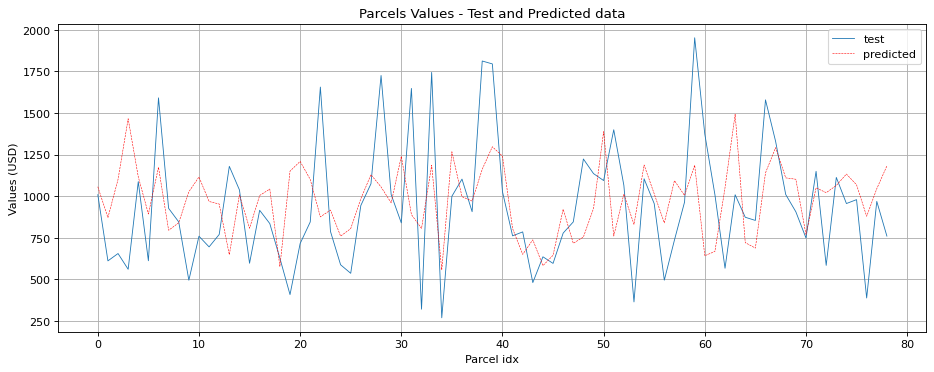

In [25]:
x_ax = range(len(y_test))
plot_predicted_vs_test(x_ax, y_test, preds, predicted_name='Values')

### 4.2. Reducción del RMSE 

Definición de parámetros para implementación de python en el siguiente [link](https://xgboost.readthedocs.io/en/stable/parameter.html). 

In [26]:
# definimos nuevos parametros más conservadores 
baseline_params = [0.3, 0.1, 5, 10, 45]

In [27]:
# exploracion de parametros alternativos
alternative_params = {
                      'colsample_bytree': np.linspace(0.1, 1, num=10), 
                      'learning_rate': np.linspace(0.1, 1, num=10), 
                      'max_depth': list(range(1,15+1)), 
                      'alpha':list(range(1,15+1)),
                      'num_boost_round': list(range(10,100+1,5)) 
                      }

In [28]:
min_rmse_scores = {}
nf = 10

for k in alternative_params.keys():
    
    if 'colsample_bytree' in k:
        colsample_bytree_scores = test_cv_parameters(k, baseline_params, alternative_params, nf, data_dmatrix)
        min_rmse_scores[k+'_scores'] = colsample_bytree_scores
    
    if 'learning_rate' in k:
        learning_rate_scores = test_cv_parameters(k, baseline_params, alternative_params, nf, data_dmatrix)
        min_rmse_scores[k+'_scores'] = learning_rate_scores
        
    if 'max_depth' in k:
        max_depth_scores = test_cv_parameters(k, baseline_params, alternative_params, nf, data_dmatrix)
        min_rmse_scores[k+'_scores'] = max_depth_scores
        
    if 'alpha' in k:
        alpha_scores = test_cv_parameters(k, baseline_params, alternative_params, nf, data_dmatrix)
        min_rmse_scores[k+'_scores'] = alpha_scores
        
    if 'num_boost_round' in k:
        num_boost_round_scores = test_cv_parameters(k, baseline_params, alternative_params, nf, data_dmatrix)
        min_rmse_scores[k+'_scores'] = num_boost_round_scores


Optimizing colsample_bytree
***************************
0.1
[0.1, 0.1, 5, 10, 45]
0.2
[0.2, 0.1, 5, 10, 45]
0.30000000000000004
[0.30000000000000004, 0.1, 5, 10, 45]
0.4
[0.4, 0.1, 5, 10, 45]
0.5
[0.5, 0.1, 5, 10, 45]
0.6
[0.6, 0.1, 5, 10, 45]
0.7000000000000001
[0.7000000000000001, 0.1, 5, 10, 45]
0.8
[0.8, 0.1, 5, 10, 45]
0.9
[0.9, 0.1, 5, 10, 45]
1.0
[1.0, 0.1, 5, 10, 45]

Optimizing learning_rate
************************
0.1
[0.3, 0.1, 5, 10, 45]
0.2
[0.3, 0.2, 5, 10, 45]
0.30000000000000004
[0.3, 0.30000000000000004, 5, 10, 45]
0.4
[0.3, 0.4, 5, 10, 45]
0.5
[0.3, 0.5, 5, 10, 45]
0.6
[0.3, 0.6, 5, 10, 45]
0.7000000000000001
[0.3, 0.7000000000000001, 5, 10, 45]
0.8
[0.3, 0.8, 5, 10, 45]
0.9
[0.3, 0.9, 5, 10, 45]
1.0
[0.3, 1.0, 5, 10, 45]

Optimizing max_depth
********************
1
[0.3, 0.1, 1, 10, 45]
2
[0.3, 0.1, 2, 10, 45]
3
[0.3, 0.1, 3, 10, 45]
4
[0.3, 0.1, 4, 10, 45]
5
[0.3, 0.1, 5, 10, 45]
6
[0.3, 0.1, 6, 10, 45]
7
[0.3, 0.1, 7, 10, 45]
8
[0.3, 0.1, 8, 10, 45]
9
[0.3, 0.1, 

Se evalúa la reducción del RMSE con el aumento de los valores de cada parametro (de más a menos conservador)

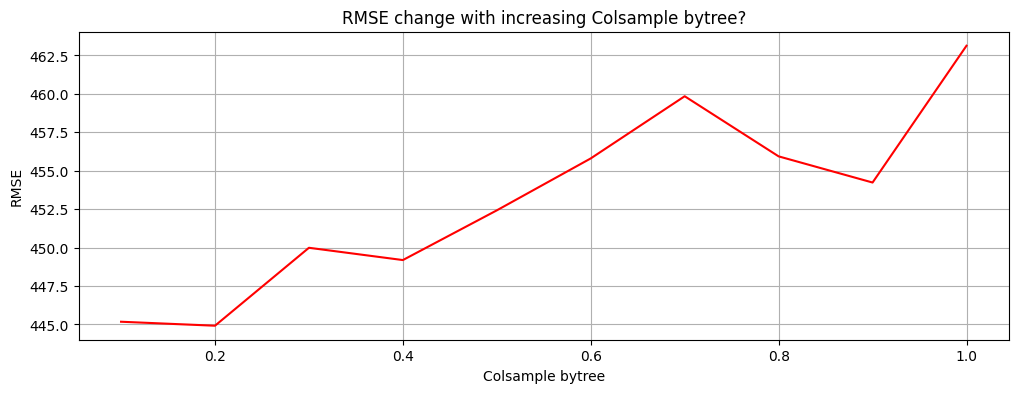

In [29]:
plot_min_rmse(alternatives=alternative_params['colsample_bytree'],
              results=min_rmse_scores['colsample_bytree_scores'],
              parameter='Colsample bytree', color='red')

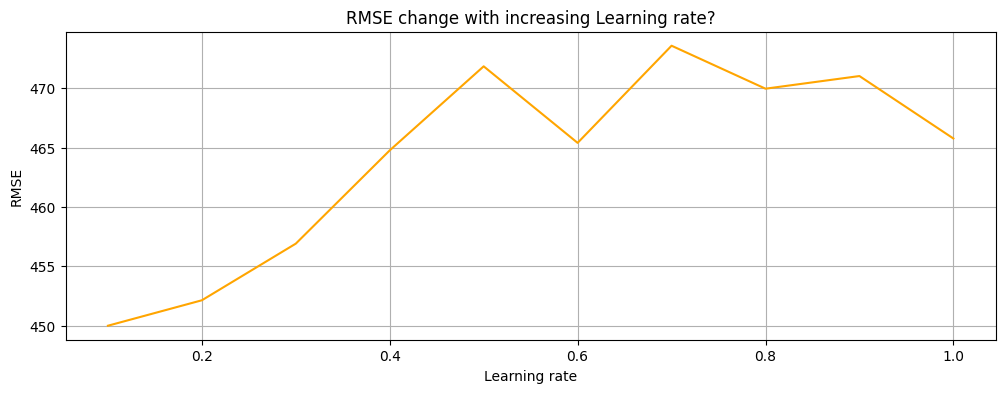

In [30]:
plot_min_rmse(alternatives=alternative_params['learning_rate'],
               results=min_rmse_scores['learning_rate_scores'],
               parameter='Learning rate', color='orange')

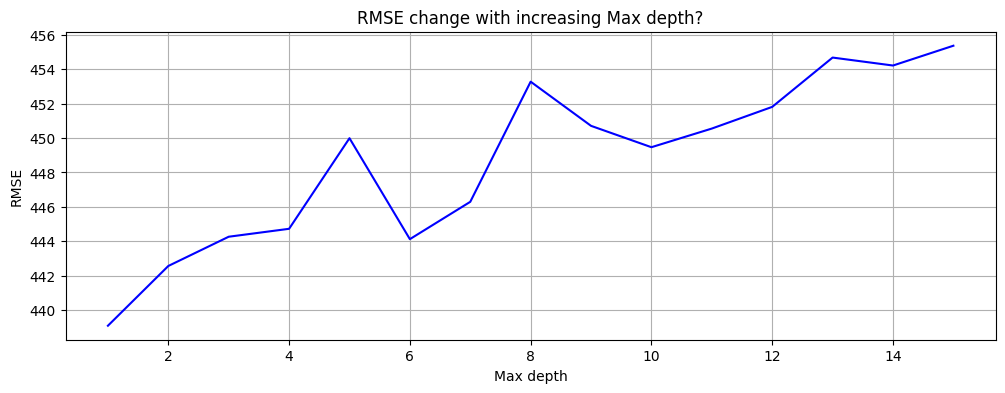

In [31]:
plot_min_rmse(alternatives=alternative_params['max_depth'],
               results=min_rmse_scores['max_depth_scores'],
               parameter='Max depth', color='blue')

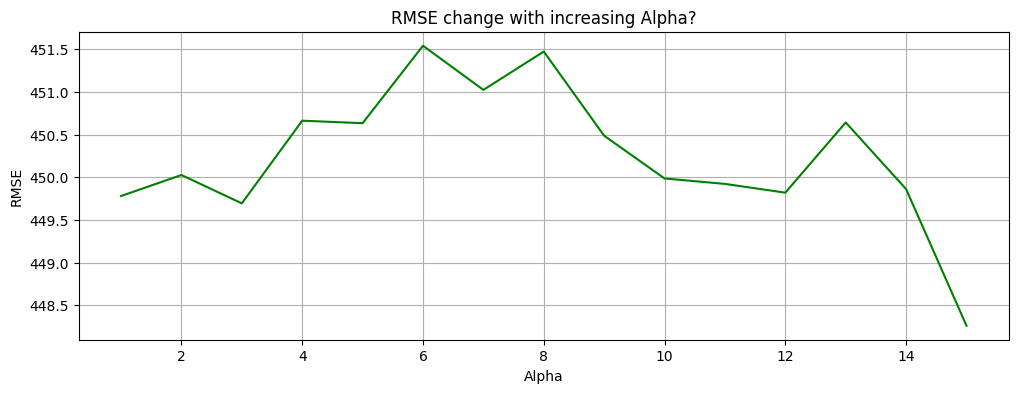

In [32]:
plot_min_rmse(alternatives=alternative_params['alpha'],
               results=min_rmse_scores['alpha_scores'],
               parameter='Alpha', color='green')

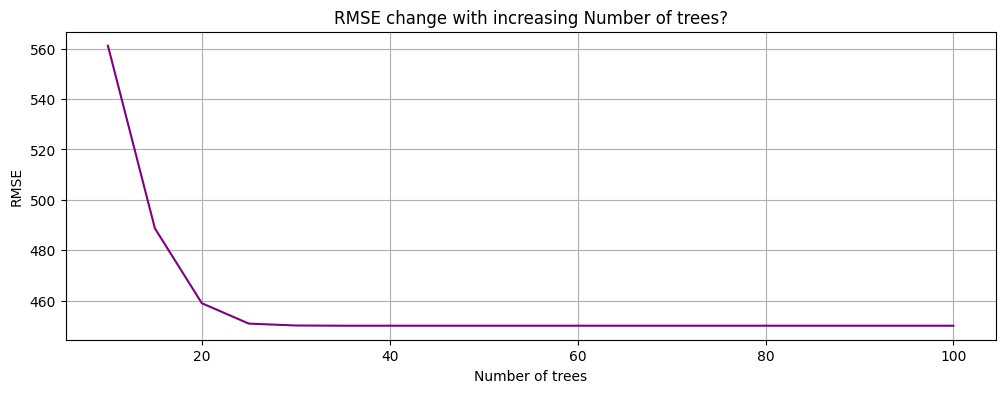

In [33]:
plot_min_rmse(alternatives=alternative_params['num_boost_round'],
               results=min_rmse_scores['num_boost_round_scores'],
               parameter='Number of trees', color='purple')

In [34]:
min_rmse_params = {}

params = ["colsample_bytree", "learning_rate", "max_depth", "alpha", "num_boost_round"]

for p in params:
    o = optimal_hyperparam(dict1=alternative_params[p], 
                           dict2=min_rmse_scores[p+'_scores'])
    min_rmse_params[p] = o

In [35]:
min_rmse_params # parametros que minimizan el RMSE

{'colsample_bytree': 0.2,
 'learning_rate': 0.1,
 'max_depth': 1,
 'alpha': 15,
 'num_boost_round': 35}

### 4.3. Restimación con min rmse de base

In [36]:
xg_reg_minrmse = xgb.XGBRegressor(objective ='reg:squarederror',
                                  colsample_bytree=0.5,# mantenemos el default
                                  learning_rate=min_rmse_params['learning_rate'],
                                  max_depth=6,# mantenemos el default
                                  alpha=min_rmse_params['alpha'],
                                  n_estimators=min_rmse_params['num_boost_round'])

xg_reg_minrmse.fit(X_train, y_train)

preds_minrmse = xg_reg_minrmse.predict(X_test)

In [37]:
print_scores(y_test, preds_minrmse) 

RMSE: 332.072197
R_Squared Score : 0.443298


La predicción mejora a un 44% con +/- USD332 de error en promedio.

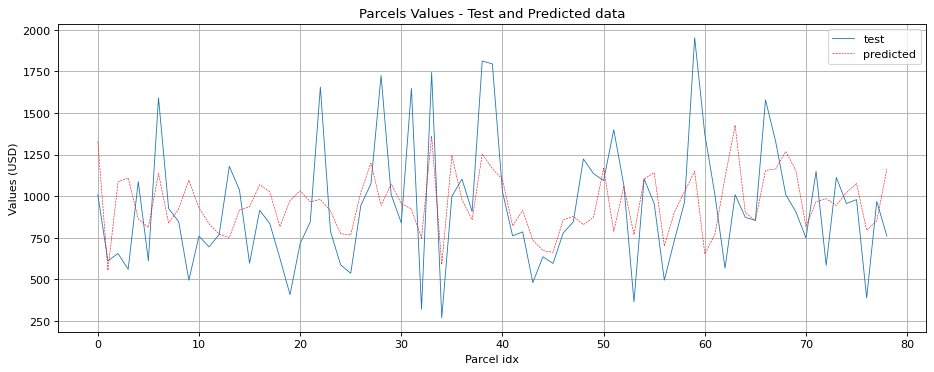

In [38]:
x_ax = range(len(y_test))
plot_predicted_vs_test(x_ax, y_test, preds_minrmse, predicted_name='Values')

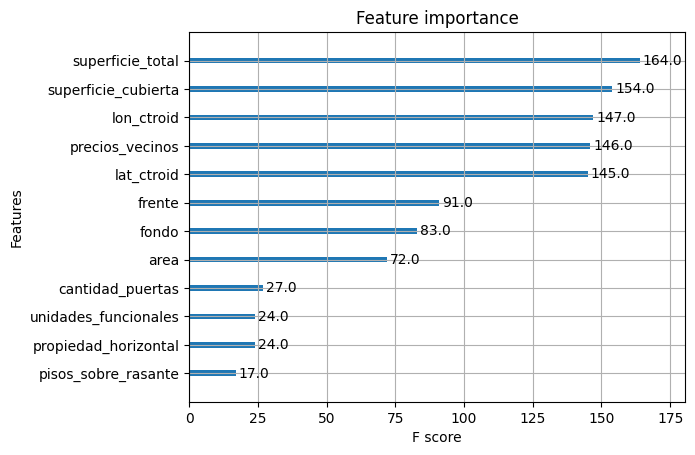

In [39]:
xgb.plot_importance(xg_reg_minrmse);

## 5. Búsqueda de mejor combinación de hiperparámetros 

TODO: Optimizar validación cruzada con Gridsearch (no escala). Se sugiere no ejecutar

In [ ]:
gs_params = {
              'n_estimators':[25, 45, 250, 500, 1000],
              'max_depth':[3,5,8],
              'learning_rate':np.linspace(0.001,0.1,4),
              'gamma':np.linspace(0,1,5),
              'min_child_weight':np.linspace(1,5,3),
              'subsample':np.linspace(0.3,0.9,3),
              'colsample_bytree':np.linspace(0.3,0.9,3),
              'reg_alpha':[0,.01,.1,.5,1],
              'reg_lambda':[0,.01,.1,.5,1],
              'scale_pos_weight':np.linspace(1,5,3)
              }

In [ ]:
gs_reg = grid_search_optimization(gs_params, X_train,y_train)

gs_reg.fit(X_train, y_train)

preds_gs = gs_reg.predict(X_test)
print_scores(y_test, preds_gs) 

## 6. Prediccion

In [40]:
from REM.utils import neighbors_mean

In [41]:
# precios vecinos en base a valores obsrvados
precios_vecinos = neighbors_mean(base_data=parcelas_sur, observation_cols=[target_var,'area'], n=10)
parcelas_sur['precios_vecinos'] = precios_vecinos

In [42]:
# imputa precios vecinos en funcion del usdm2 obervado en parcelas con oferta
precios_vecinos_dict = dict(zip(parcelas_sur['smp'], parcelas_sur['precios_vecinos']))
parcelas_sprecio['precios_vecinos'] = parcelas_sprecio['smp'].map(precios_vecinos_dict) 
parcelas_sprecio_idx = parcelas_sprecio[['smp','precios_vecinos','area']].copy()
parcelas_feat = parcelas_sprecio_idx.set_index('smp').join(xvars_df[expvars]).reset_index()

In [43]:
# predicción en base al mejor regresor obtenido
pred_usdm2 = xg_reg_minrmse.predict(parcelas_feat.set_index('smp'))

In [44]:
# agrega prediccion
parcelas_feat[target_var] = pred_usdm2

In [45]:
# mapea valores predichos a dataset sin precios observados
parcelas_pred = dict(zip(parcelas_feat.smp, parcelas_feat[target_var]))
parcelas_sprecio[target_var] = parcelas_sprecio['smp'].map(parcelas_pred)

In [46]:
# concatena precios predichos y observados
resultado = pd.concat([parcelas_sprecio[['smp',target_var,'geometry']], 
                       parcelas_cprecio[['smp',target_var,'geometry']]])

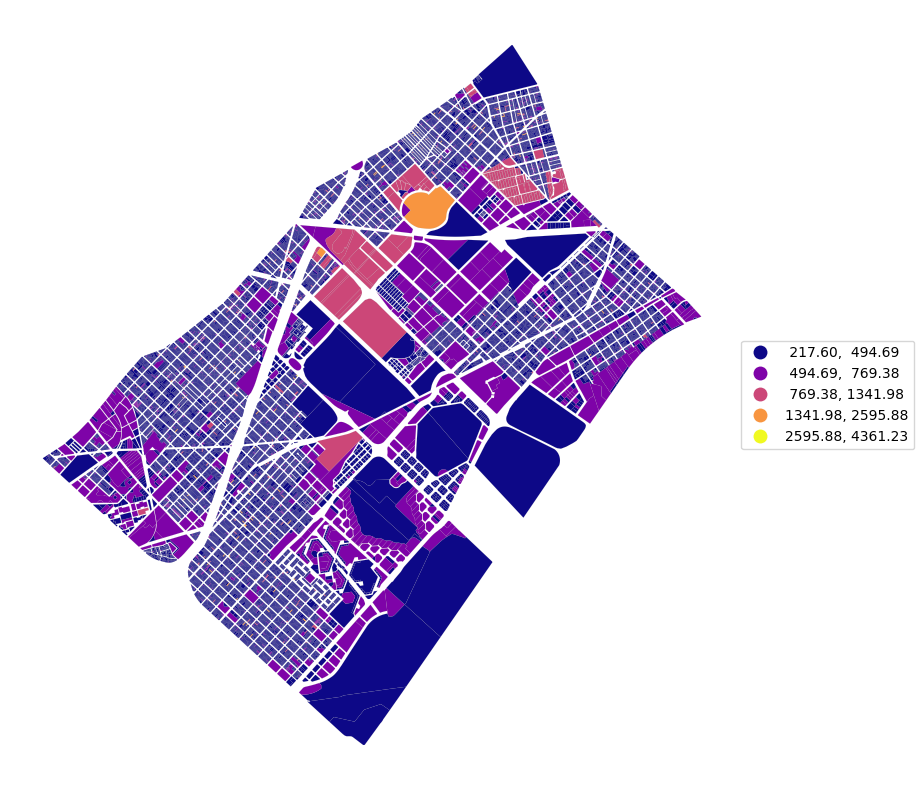

In [47]:
f, ax = plt.subplots(figsize=(16,10))

resultado.plot(column=target_var, ax=ax, 
               k=5, cmap='plasma', 
               scheme='NaturalBreaks', edgecolor='gray', linewidth=0.05,
               legend=True, legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5)},)
               
ax.set_axis_off();

### 6.1. Exporta modelo entrenado

Se guarda el mejor modelo obtenido

In [49]:
import joblib
joblib.dump(xg_reg_minrmse, "../prices/parcels_pred_12092022.json") 

['../prices/parcels_pred_12092022.json']